In [1]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

# Definition of data

In [2]:
N = 6 # Number of generators
T = 24 # Time periods

generation_costs = np.array([15, 20, 15, 20, 30, 25.])
startup_costs = np.array([75, 100, 75, 100, 100, 125.])
shutdown_costs = np.array([7.5, 10.0, 7.5, 10.0, 10.0, 12.5])
running_costs = np.array([10, 5, 10, 10, 10, 10.])

capacity = np.array([10, 5, 10, 10, 20, 30.])
ramp_up_rate = np.array([2, 5, 2, 5, 10, 5.])
ramp_down_rate = np.array([2, 5, 2, 5, 10, 5.])

initial_state = np.array([1, 0, 0, 0, 0, 0])

In [3]:
rt = np.array([15.2, 16.4, 16.1, 10.9, 14.8, 7.6, 15.6, 5.5, 9.2, 5.7, 1.5, 12.4, 10.4, 4.8, 14.3, 0.5, 6.6, 5.7, 11.5, 11.9, 2.8, 7.3, 6.7, 9.7])
dt = np.array([21.3, 21.4, 17.8, 20.9, 15.5, 17.6, 20.2, 23.8, 27.7, 30.1, 35.4, 39.4, 43.2, 47.0, 49.3, 51.5, 52.6, 50.3, 47.0, 43.1, 38.8, 33.2, 28.6, 24.3])

# Question 2.2

In [4]:
Tup = 3
Tdown = 2

In [5]:
# YOUR CODE HERE
# Hint: Define decision variables in CVXPY using
# shape = (2,2) # example: 2x2 binary matrix
# binary_example_variable = cp.Variable(shape, boolean=True)
# We recommend GLPK_MI solver


# Define variables
g = cp.Variable((T, N))
x = cp.Variable((T, N), boolean = True)
u = cp.Variable((T, N), boolean = True)
v = cp.Variable((T, N), boolean = True)

In [6]:
# Define objective
obj = cp.Minimize(sum(generation_costs@g.T + startup_costs@u.T + shutdown_costs@v.T + running_costs@x.T))

In [7]:
# Define Constraints

# Non-neg constraints
cons = [g >= 0]

# First time period
cons.append( sum(g[0,:]) + rt[0] == dt[0])
cons.append(x[0,:] == initial_state)
cons.append(u[0,:] == 0)
cons.append(v[0,:] == 0)

#Rest of time periods
for t in range(1, T):
    cons.append( sum(g[t,:]) + rt[t] == dt[t]) # Demand is met
    cons.append(x[t-1,:] - x[t,:] + u[t,:] >= 0) # Write smt here
    cons.append(x[t,:] - x[t-1,:] + v[t,:] >= 0) # Write smt here

# For each t except first and last
for t in range(1, T-1):
    tau_up = min(t + Tup, T)  # Calculate the max T_up
    for tau_u in range(t+1, tau_up):
        cons.append(x[t,:] - x[t-1,:] <= x[tau_u,:]) # T up cons
        
    tau_down = min(t + Tup, T)  # Calculate max T_down
    for tau_d in range(t+1, tau_down):
        cons.append(x[t-1,:] - x[t,:] <= 1 - x[tau_d,:]) # T down cons
    
# For all the generators    
for n in range(N):
    cons.append(g[:, n] <= x[:, n]*capacity[n]) # Capacity cons

In [8]:
# Solve

# Measure time
start = time.time() # Time starts

# Solve problem
problem = cp.Problem(obj, cons)
problem.solve(solver = 'ECOS_BB')

end = time.time() # Time ends

print('Objective value: ' + str(obj.value))
print('Time elapsed: ' + str(end - start) + ' seconds')

Objective value: 11029.500000015461
Time elapsed: 80.07891154289246 seconds


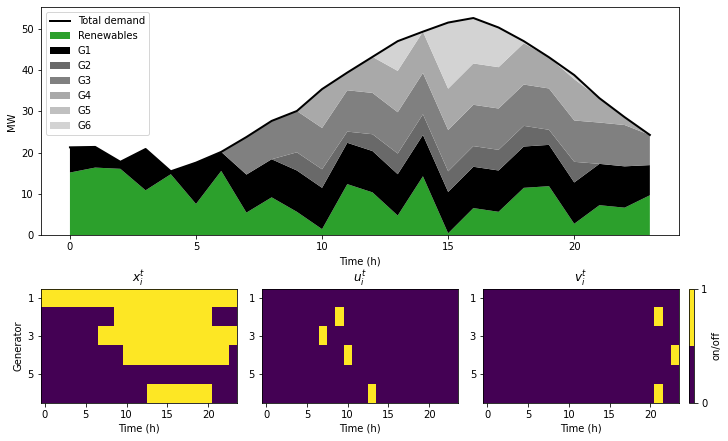

In [9]:
# Plot results
df = pd.DataFrame(abs(g.value), columns=['G1', 'G2', 'G3', 'G4', 'G5', 'G6'])
df.insert(0, 'Renewables', rt)

# Color palette
colors = ['tab:green', 'black', 'dimgray', 'gray', 'darkgrey', 'silver', 'lightgray']

# Define figure
fig = plt.subplots(figsize = (10, 6), constrained_layout=True)

# Create subplot grid
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan = 3, rowspan = 2)
ax2 = plt.subplot2grid((3, 3), (2, 0))
ax3 = plt.subplot2grid((3, 3), (2, 1))
ax4 = plt.subplot2grid((3, 3), (2, 2))

# Dispatch plot
ax1.stackplot(np.arange(T), df.T, labels= df.columns, colors = colors)
ax1.plot(dt, linewidth=2, c = 'k', label = 'Total demand')
ax1.set_ylabel('MW')
ax1.set_xlabel('Time (h)')
ax1.legend()

# X plot
ax2.imshow(x.value.T, interpolation='nearest', aspect='auto')
ax2.set_xlabel('Time (h)')
ax2.set_ylabel('Generator')
ax2.set_title('$x_i^t$')
ax2.set_yticklabels(['1', '1', '3', '5'])

# U plot
ax3.imshow(u.value.T, interpolation='nearest', aspect='auto')
ax3.set_xlabel('Time (h)')
ax3.set_title('$u_i^t$')
ax3.set_yticklabels(['1', '1', '3', '5'])

# V plot
ax4.imshow(v.value.T, interpolation='nearest', aspect='auto')
ax4.set_xlabel('Time (h)')
ax4.set_title('$v_i^t$')
ax4.set_yticklabels(['1', '1', '3', '5'])

# Binary colorbar
plt.colorbar(ax2.imshow(x.value.T, interpolation='nearest', aspect='auto'), ticks=[0, 1], label='on/off', values = [1,0])

plt.savefig('.\\plots\\part2_MILP.pdf')

# Question 2.3 Relaxed

In [10]:
Tup = 3
Tdown = 2

In [11]:
# Define variables
g = cp.Variable((T, N))
x = cp.Variable((T, N), boolean = True)
u = cp.Variable((T, N))
v = cp.Variable((T, N))

In [12]:
# Define objective
obj = cp.Minimize(sum(generation_costs@g.T + startup_costs@u.T + shutdown_costs@v.T + running_costs@x.T))

In [13]:
# Define Constraints

# Non-neg constraints
cons = [g >= 0]

# First time period
cons.append( sum(g[0,:]) + rt[0] == dt[0])
cons.append(x[0,:] == initial_state)
cons.append(u[0,:] == 0)
cons.append(v[0,:] == 0)

# Relaxation cons geq 0
#cons.append(x >= 0)
cons.append(u >= 0)
cons.append(v >= 0)

# Relaxation cons leq 1
cons.append(x <= 1)
cons.append(u <= 1)
cons.append(v <= 1)

for t in range(1, T):
    cons.append( sum(g[t,:]) + rt[t] == dt[t]) # Demand is met
    cons.append(x[t-1,:] - x[t,:] + u[t,:] >= 0)
    cons.append(x[t,:] - x[t-1,:] + v[t,:] >= 0)

for t in range(1, T-1):
    tau_up = min(t + Tup, T)  # Calculate max T_up
    for tau_u in range(t+1, tau_up):
        cons.append(x[t,:] - x[t-1,:] <= x[tau_u,:])
        
    tau_down = min(t + Tup, T)   # Calculate max T_down
    for tau_d in range(t+1, tau_down):
        cons.append(x[t-1,:] - x[t,:] <= 1 - x[tau_d,:])
    
# For all the generators    
for n in range(N):
    cons.append(g[:, n] <= x[:, n]*capacity[n]) # Capacity cons

In [14]:
# Solve

# Measure time
start = time.time() # Time starts

# Solve problem
problem = cp.Problem(obj, cons)
problem.solve(solver = 'ECOS_BB')

end = time.time() # Time ends

print('Objective value: ' + str(obj.value))
print('Time elapsed: ' + str(end - start) + ' seconds')

Objective value: 11024.500000159895
Time elapsed: 41.159552574157715 seconds


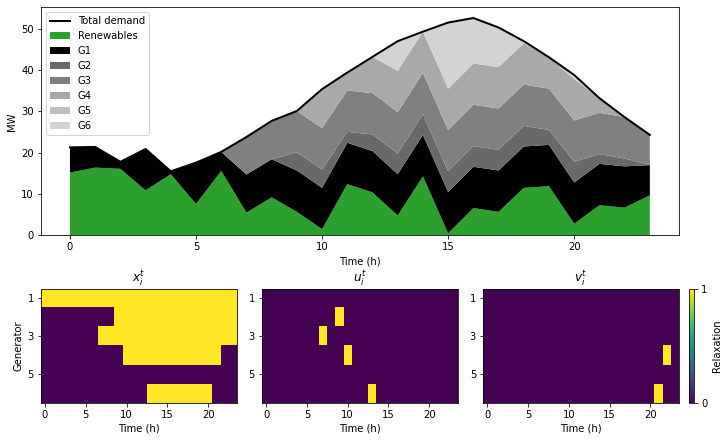

In [15]:
# Plot results
df = pd.DataFrame(abs(g.value), columns=['G1', 'G2', 'G3', 'G4', 'G5', 'G6'])
df.insert(0, 'Renewables', rt)

# Color palette
colors = ['tab:green', 'black', 'dimgray', 'gray', 'darkgrey', 'silver', 'lightgray']

# Define figure
fig = plt.subplots(figsize = (10, 6), constrained_layout=True)

# Create subplot grid
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan = 3, rowspan = 2)
ax2 = plt.subplot2grid((3, 3), (2, 0))
ax3 = plt.subplot2grid((3, 3), (2, 1))
ax4 = plt.subplot2grid((3, 3), (2, 2))

# Dispatch plot
ax1.stackplot(np.arange(T), df.T, labels= df.columns, colors = colors)
ax1.plot(dt, linewidth=2, c = 'k', label = 'Total demand')
ax1.set_ylabel('MW')
ax1.set_xlabel('Time (h)')
ax1.legend()

# X plot
ax2.imshow(x.value.T, interpolation='nearest', aspect='auto')
ax2.set_xlabel('Time (h)')
ax2.set_ylabel('Generator')
ax2.set_title('$x_i^t$')
ax2.set_yticklabels(['1', '1', '3', '5'])

# U plot
ax3.imshow(u.value.T, interpolation='nearest', aspect='auto')
ax3.set_xlabel('Time (h)')
ax3.set_title('$u_i^t$')
ax3.set_yticklabels(['1', '1', '3', '5'])

# V plot
ax4.imshow(v.value.T, interpolation='nearest', aspect='auto')
ax4.set_xlabel('Time (h)')
ax4.set_title('$v_i^t$')
ax4.set_yticklabels(['1', '1', '3', '5'])

# Binary relaxation colorbar
plt.colorbar(ax2.imshow(x.value.T, interpolation='nearest', aspect='auto'), ticks=[0, 1], label='Relaxation')

plt.savefig('.\\plots\\part2_relax.pdf')